In [1]:
from env_hiv import HIVPatient
import gymnasium as gym
env = HIVPatient()
import numpy as np
def rew(state,action, env) : 
    return-(
                env.Q * state[4]
                + env.R1 * action[0] ** 2
                + env.R2 * action[1] ** 2
                - env.S * state[5]
            )
low_r, high_r = rew(env.lower, [1,1],env),rew(env.upper, [1,1],env)
def scale_state_reward(reward,state2):
    state2 = np.log(1e-9+state2)
    reward = np.log(-low_r+reward)
    return reward,state2
from scipy.stats import loguniform
def sample_states(n_states):
    states = []
    for i in range(n_states):
        a,b = np.log(env.lower[i]+1e-9),np.log(env.upper[i]+1e-9)
        states.append(np.random.uniform(a,b))
    return np.array(states)

In [64]:
import joblib
def sample_append(env):
    x=sample_states(env.observation_space.shape[0])
    env.T1 = np.exp(x[0])
    env.T1star = np.exp(x[1])
    env.T2 = np.exp(x[2])
    env.T2star = np.exp(x[3])
    env.V = np.exp(x[4])
    env.E = np.exp(x[5])
    a = env.action_space.sample()
    y,r,d,t,i  = env.step(a)
    r,y = scale_state_reward(r,y)
    return x, y,r,a
def collect_data(env,n):
    X,Y, R ,A= [],[],[],[]
    raw = joblib.Parallel(n_jobs=18)(joblib.delayed(sample_append)(env) for i in range(n))
    for d in raw : 
        x,y,r,a =  d
        X.append(x), Y.append(y),R.append(r),A.append(a)
    return np.array(X),np.array(Y),np.array(R),np.array(A)
X,Y,R,A = collect_data(env,100000)

In [65]:
import pickle
data = {"X":X,"Y":Y,"R":R,"A":A}
with open('offlinedata.pkl',"wb") as f : 
    pickle.dump(data,f)

In [2]:
import pickle
with open('offlinedata.pkl',"rb") as f : 
    data = pickle.load(f)
X = data['X']
Y = data['Y']
A = data['A']
R = data['R']

In [3]:
import numpy as np
import gc
gc.collect()
from sklearn.ensemble import RandomForestRegressor
from tqdm import tqdm

def rf_fqi(S, A, R, S2, D, iterations, nb_actions, gamma, disable_tqdm=False):
    nb_samples = S.shape[0]
    Qfunctions = []
    SA = np.append(S,A,axis=1)
    for iter in tqdm(range(iterations), disable=disable_tqdm):
        if iter==0:
            value=R.copy()
        else:
            Q2 = np.zeros((nb_samples,nb_actions))
            for a2 in range(nb_actions):
                A2 = a2*np.ones((S.shape[0],1))
                S2A2 = np.append(S2,A2,axis=1)
                Q2[:,a2] = Qfunctions[-1].predict(S2A2)
            max_Q2 = np.max(Q2,axis=1)
            value = R + gamma*(1-D)*max_Q2
        Q = RandomForestRegressor(n_jobs = 18)
        Q.fit(SA,value)
        Qfunctions.append(Q)
    return Qfunctions
gamma = 1
nb_iter = 10
nb_actions = env.action_space.n
sampling =len(X)
Qfunctions=rf_fqi(S=np.exp(X[:sampling]),A=A[:sampling].reshape(-1,1),R=np.exp(R[:sampling]),S2 = np.exp(Y[:sampling]), D= np.zeros(sampling),iterations=nb_iter, nb_actions=nb_actions, gamma=gamma)

100%|██████████| 10/10 [01:11<00:00,  7.14s/it]


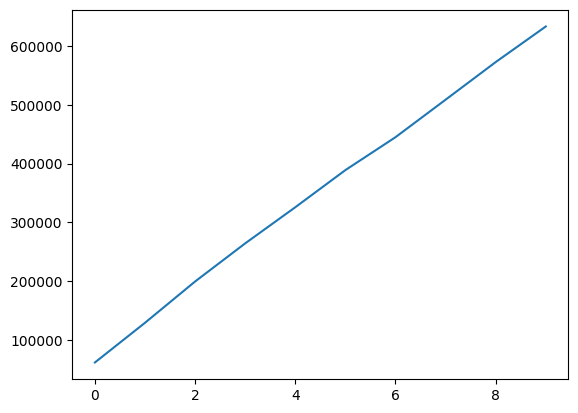

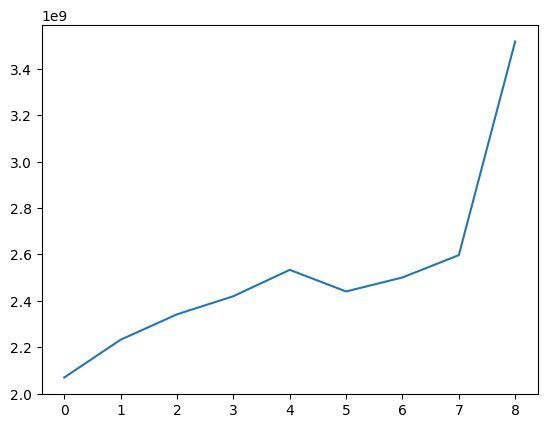

In [4]:
import matplotlib.pyplot as plt

SA = np.append(X[:sampling],A[:sampling].reshape(-1,1),axis=1)
# Value of an initial state across iterations
s0,_ = env.reset()
Vs0 = np.zeros(nb_iter)
for i in range(nb_iter):
    Qs0a = []
    for a in range(env.action_space.n):
        s0a = np.append(s0,a).reshape(1, -1)
        Qs0a.append(Qfunctions[i].predict(s0a))
    Vs0[i] = np.max(Qs0a)
plt.plot(Vs0)

# Bellman residual
residual = []
for i in range(1,nb_iter):
    residual.append(np.mean((Qfunctions[i].predict(SA)-Qfunctions[i-1].predict(SA))**2))
plt.figure()
plt.plot(residual);

In [5]:
def greedy_action(Q,s,nb_actions):
    Qsa = []
    for a in range(nb_actions):
        sa = np.append(s,a).reshape(1, -1)
        Qsa.append(Q.predict(sa))
    return np.argmax(Qsa)
class ProjectAgent : 
    def __init__(self,Q) -> None:
        self.Q = Q
    def act(self, obs, use_random =False) : 
        #obs = np.log(1e-9+obs)
        a = greedy_action(self.Q , obs, 4)
        print(a)
        return a
agent = ProjectAgent(Qfunctions[-1])

In [10]:
import random , torch , os
def seed_everything(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)


from evaluate import *
seed_everything(seed=42)
# Initialization of the agent. Replace DummyAgent with your custom agent implementation.

# Keep the following lines to evaluate your agent unchanged.
score_agent: float = evaluate_HIV(agent=agent, nb_episode=1)
score_agent_dr: float = evaluate_HIV_population(agent=agent, nb_episode=15)
with open(file="score.txt", mode="w") as f:
    f.write(f"{score_agent}\n{score_agent_dr}")
print('indiv ', {"{:e}".format(score_agent)})
print('pop ', {"{:e}".format(score_agent_dr)})


KeyboardInterrupt: 

In [13]:
X[0]

array([  2.06908548,   0.57688119,  -7.79973741,   2.46665386,
        -4.12519014, -13.55533514])

In [6]:
import random , torch , os
def seed_everything(seed: int = 42):
    random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False
    torch.cuda.manual_seed_all(seed)


from evaluate import *
seed_everything(seed=42)
score_agent: float = evaluate_HIV(agent=agent, nb_episode=1)
print('indiv ', {"{:e}".format(score_agent)})

0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
0
indiv  {'3.432808e+06'}
